# Satellite Imagery

To plot satellite imagery we can use data that we bring in through our local data feed. Satellite data are stored in ```/data/ldmdata/satellite``` for both GOES-16 and GOES-17. There are a couple of different sectors that we can view the data from, but the most common for synoptic-dynamic purposes would be the CONUS projection. Data are available every 5 min.

For this plotting we are doing to use the declarative plotting syntax using Python and the MetPy module.

### Import Packages

In [1]:
from datetime import datetime

import metpy.calc as mpcalc
from metpy.plots import ImagePlot, ContourPlot, MapPanel, PanelContainer
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

### Helper Function

In [2]:
def get_satellite_file_url(datasets, date):
    '''A function to help find the desired satellite data based on the time given.
    
    Input:
     - List of datasets from a THREDDS Catalog
     - Date of desired dataset (datetime object)
     
    Output:
     - Index value of dataset closest to desired time
    '''
    sat_date_hour = date.strftime('%Y%j%H')
    files = []
    times = []
    for file in cat.datasets:
        if sat_date_hour in file:
            times.append(datetime.strptime(file.split('_')[3][1:-3], '%Y%j%H%M'))
            files.append(file)
    find_file = np.abs(np.array(times) - date)
    return list(cat.datasets).index(files[np.argmin(find_file)])

### Get Data

In [4]:
date = datetime(2024, 5, 31, 15, 30)

# Create variables for URL generation
region = 'CONUS'
channel = 2
satellite = 'east'

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string
data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
            f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
            f'{date:%Y%m%d}/catalog.xml')

# Get list of files available for particular day
cat = TDSCatalog(data_url)

# Use homemade function to get dataset for desired time
dataset = cat.datasets[get_satellite_file_url(cat.datasets, date)]

# Open most recent file available
ds = dataset.remote_access(use_xarray=True)

# Apply a square root correction for visible imagery only
if channel == 2:
    ds['Sectorized_CMI'].values = np.sqrt(ds['Sectorized_CMI'].values)

# Grab time from file and make into datetime object for plotting and later data access
vtime = ds.time.values.astype('datetime64[ms]').astype('O')

### Plot Imagery

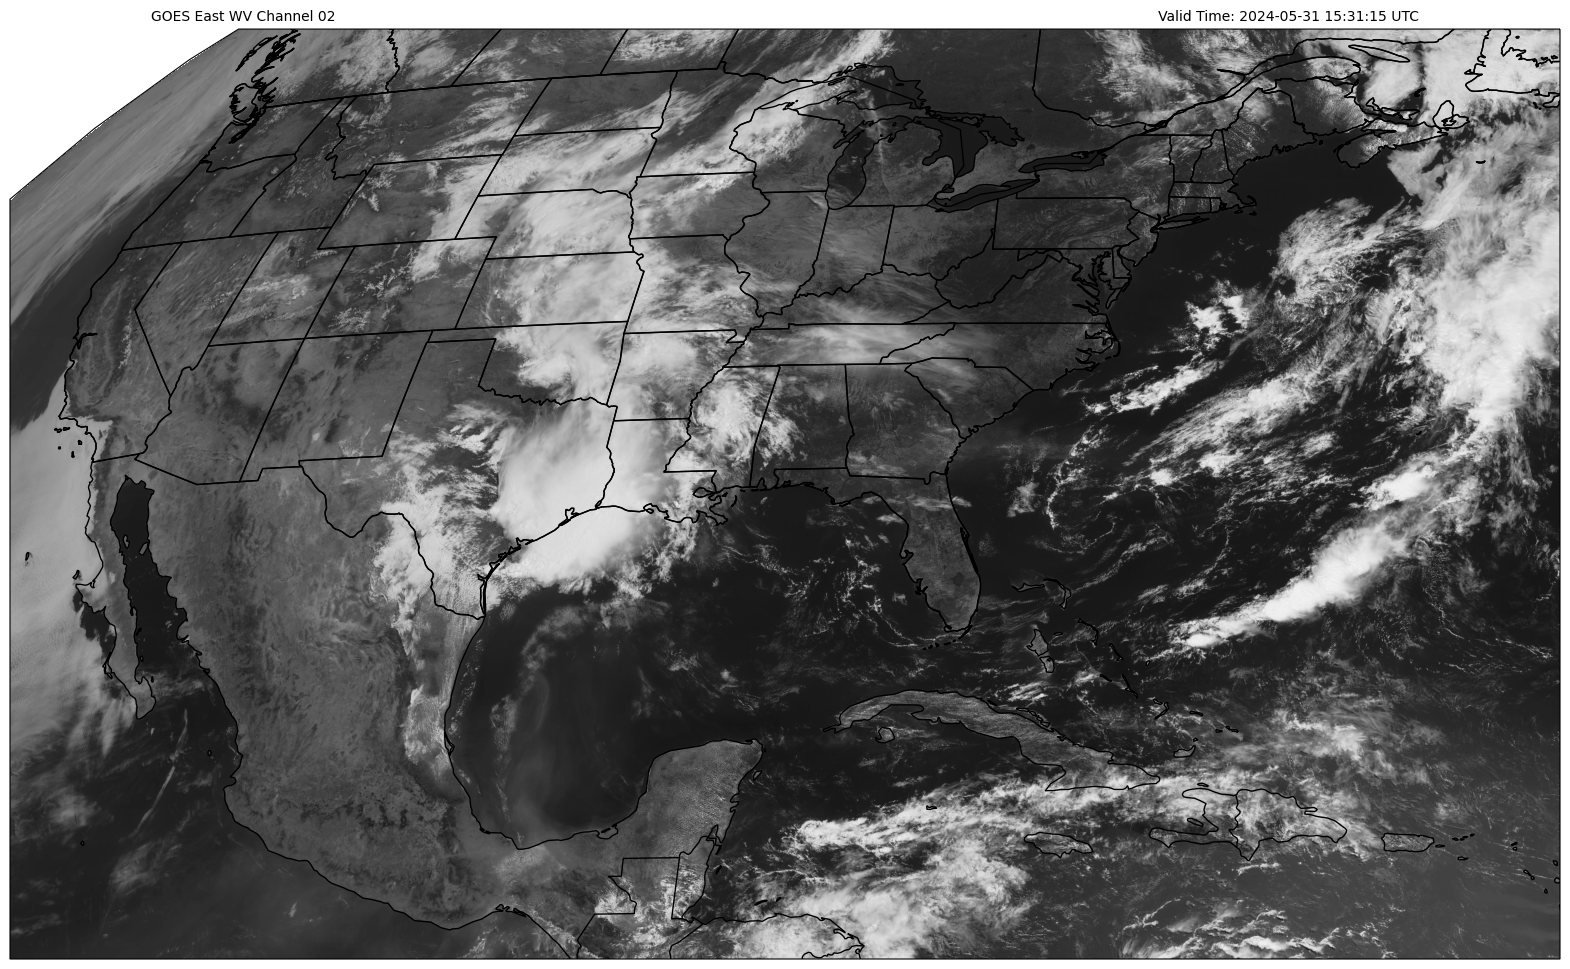

In [5]:
# Declare the data we wish to plot
img = ImagePlot()
img.data = ds
img.field = 'Sectorized_CMI'
img.colormap = 'Greys_r'

# Plot the data on a map
panel = MapPanel()
panel.layers = ['coastline', 'borders', 'states']
panel.title = f"{f'GOES East WV Channel {channel:02d}':<123}{f'Valid Time: {vtime} UTC':>123}"
panel.plots = [img]

# Place the map on a figure
pc = PanelContainer()
pc.size = (20, 16)
pc.panels = [panel]
pc.show()